# Small World Graphs

Code examples from [Think Complexity, 2nd edition](https://thinkcomplex.com).

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [1]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/utils.py')

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns

from utils import decorate, savefig

# Set the random seed so the notebook 
# produces the same results every time.
np.random.seed(17)

In [3]:
# make a directory for figures
!mkdir -p figs

In [4]:
# node colors for drawing networks
colors = sns.color_palette('pastel', 5)
#sns.palplot(colors)
sns.set_palette(colors)

## Regular ring lattice

To make a ring lattice, I'll start with a generator function that yields edges between each node and the next `halfk` neighbors.

In [5]:
def adjacent_edges(nodes, halfk):
    """Yields edges between each node and `halfk` neighbors.
    
    halfk: number of edges from each node
    """
    n = len(nodes)
    for i, u in enumerate(nodes):
        for j in range(i+1, i+halfk+1):
            v = nodes[j % n]
            yield u, v

We can test it with 3 nodes and `halfk=1`

In [6]:
nodes = range(3)
for edge in adjacent_edges(nodes, 1):
    print(edge)

(0, 1)
(1, 2)
(2, 0)


Now we use `adjacent_edges` to write `make_ring_lattice`

In [7]:
def make_ring_lattice(n, k):
    """Makes a ring lattice with `n` nodes and degree `k`.
    
    Note: this only works correctly if k is even.
    
    n: number of nodes
    k: degree of each node
    """
    G = nx.Graph()
    nodes = range(n)
    G.add_nodes_from(nodes)
    G.add_edges_from(adjacent_edges(nodes, k//2))
    return G

And we can test it out with `n=10` and `k=4`

In [8]:
lattice = make_ring_lattice(10, 6)

Saving figure to file figs/chap03-1


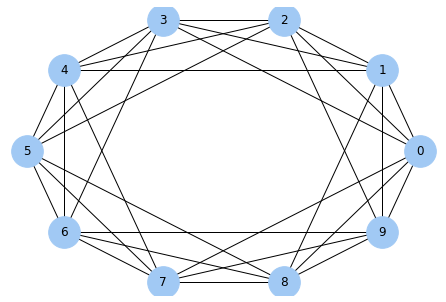

In [9]:
nx.draw_circular(lattice, 
                 node_color='C0', 
                 node_size=1000, 
                 with_labels=True)

savefig('figs/chap03-1')

**Exercise:** To see how this function fails when `k` is odd, run it again with `k=3` or `k=5`.

Saving figure to file figs/chap03-1-ring-lattice-3k


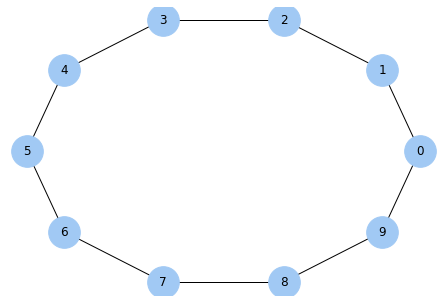

In [10]:
# Solution goes here
lattice = make_ring_lattice(10, 3)
nx.draw_circular(lattice, 
                 node_color='C0', 
                 node_size=1000, 
                 with_labels=True)

savefig('figs/chap03-1-ring-lattice-3k')

Saving figure to file figs/chap03-1-ring-lattice-5k


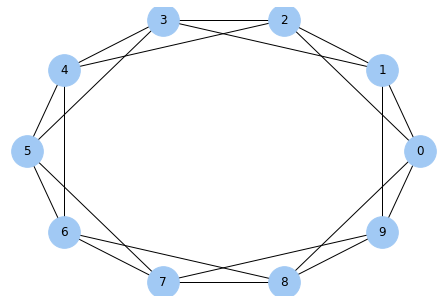

In [11]:
# Solution goes here
lattice = make_ring_lattice(10, 5)
nx.draw_circular(lattice, 
                 node_color='C0', 
                 node_size=1000, 
                 with_labels=True)

savefig('figs/chap03-1-ring-lattice-5k')

One of the exercises below asks you to explore regular graphs with odd values of `k`.

## WS graph

To make a WS graph, you start with a ring lattice and then rewire.

In [12]:
def make_ws_graph(n, k, p):
    """Makes a Watts-Strogatz graph.
    
    n: number of nodes
    k: degree of each node
    p: probability of rewiring an edge
    """
    ws = make_ring_lattice(n, k)
    rewire(ws, p)
    return ws

To do the rewiring, we'll need `flip`.

In [13]:
def flip(p):
    """Returns True with probability `p`."""
    return np.random.random() < p

Here's the function that does the rewiring

In [14]:
def rewire(G, p):
    """Rewires each edge with probability `p`.
    
    G: Graph
    p: float
    """
    nodes = set(G) 
    for u, v in G.edges(): 
        if flip(p): 
            choices = nodes - {u} - set(G[u]) 
            new_v = np.random.choice(list(choices)) 
            G.remove_edge(u, v) 
            G.add_edge(u, new_v) 

In [15]:
# Solution goes here

Here's an example with `p=0.2`

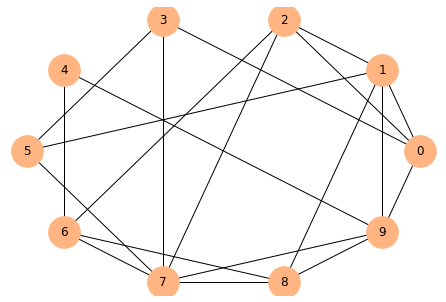

In [16]:
ws = make_ws_graph(10, 4, 0.2)
nx.draw_circular(ws, 
                 node_color='C1', 
                 node_size=1000, 
                 with_labels=True)

Just checking that we have the same number of edges we started with:

In [17]:
len(lattice.edges()), len(ws.edges())

(20, 20)

Now I'll generate a plot that shows WS graphs for a few values of `p`

Saving figure to file figs/chap03-2


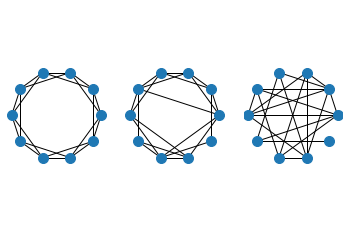

In [18]:
n = 10
k = 4
ns = 100

plt.subplot(1,3,1)
ws = make_ws_graph(n, k, 0)
nx.draw_circular(ws, node_size=ns)
plt.axis('equal')

plt.subplot(1,3,2)
ws = make_ws_graph(n, k, 0.2)
nx.draw_circular(ws, node_size=ns)
plt.axis('equal')

plt.subplot(1,3,3)
ws = make_ws_graph(n, k, 1.0)
nx.draw_circular(ws, node_size=ns)
plt.axis('equal')

savefig('figs/chap03-2')

**Exercise:** What is the order of growth of `rewire`?

In [19]:
# Solution goes here
# If "order of growth" refers to big O, then O(n^2)

## Clustering

The following function computes the local clustering coefficient for a given node, `u`:

In [20]:
def node_clustering(G, u):
    """Computes local clustering coefficient for `u`.
    
    G: Graph
    u: node
    
    returns: float
    """
    neighbors = G[u]
    k = len(neighbors)
    if k < 2:
        return np.nan
        
    possible = k * (k-1) / 2
    exist = 0    
    for v, w in all_pairs(neighbors):
        if G.has_edge(v, w):
            exist +=1
    return exist / possible

In [21]:
def all_pairs(nodes):
    """Generates all pairs of nodes."""
    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            if i < j:
                yield u, v

The network average clustering coefficient is just the mean of the local CCs.

In [22]:
def clustering_coefficient(G):
    """Average of the local clustering coefficients.
    
    G: Graph
    
    returns: float
    """
    return np.mean([node_clustering(G,u) for u in G.nodes()])


In a ring lattice with `k=4`, the clustering coefficient for each node should be 0.5

In [23]:
lattice = make_ring_lattice(10, 4)
node_clustering(lattice, 1)

0.5

And the network average should be 0.5

In [24]:
clustering_coefficient(lattice)

0.5

Correct.

In [25]:
%timeit clustering_coefficient(lattice)

58.6 µs ± 2.52 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


**Exercise:** Write a version of `node_clustering` that replaces the `for` loop with a list comprehension.  Is it faster?
It is in fact not any faster.

In [26]:
# Solution goes here
def node_clustering(G, u):
    """Computes local clustering coefficient for `u`.
    
    G: Graph
    u: node
    
    returns: float
    """
    neighbors = G[u]
    k = len(neighbors)
    if k < 2:
        return np.nan
        
    possible = k * (k-1) / 2
    exist = [1 for v, w in all_pairs(neighbors) if G.has_edge(v,w)]

    return sum(exist) / possible

In [27]:
%timeit clustering_coefficient(lattice)

59.4 µs ± 921 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


**Exercise:** What is the order of growth of `clustering_coefficient` in terms of `n`, `m`, and `k`?

In [28]:
# Solution goes here
# So, clustering coefficient calls node clustering n times; 
# node clustering calls all pairs k times;
# all pairs has two for loops of length k, thus k^2.
# Therefore, O(n*k^2); m doesn't seem to figure into this.

## Path length

The following function computes path lengths between all pairs of nodes

In [29]:
def path_lengths(G):
    #length_map = nx.shortest_path_length(G) 
    lengths = [nx.shortest_path_length(G,u,v) for u, v in all_pairs(G)]
    return lengths 

The characteristic path length is the mean path length for all pairs.

In [30]:
def characteristic_path_length(G):
    return np.mean(list(path_lengths(G)))

On a complete graph, the average path length should be 1

In [31]:
complete = nx.complete_graph(10)
characteristic_path_length(complete)

1.0

On a ring lattice with `n=1000` and `k=10`, the mean is about 50

In [32]:
lattice = make_ring_lattice(1000, 10)
characteristic_path_length(lattice)

50.450450450450454

**Exercise:**  What is the mean path length in a ring lattice with `n=10` and `k=4`?

In [33]:
# Solution goes here
lattice = make_ring_lattice(10, 4)
characteristic_path_length(lattice)

1.6666666666666667

## The experiment

This function generates a WS graph with the given parameters and returns a pair of (mean path length, clustering coefficient):

In [34]:
def run_one_graph(n, k, p):
    """Makes a WS graph and computes its stats.
    
    n: number of nodes
    k: degree of each node
    p: probability of rewiring
    
    returns: tuple of (mean path length, clustering coefficient)
    """
    ws = make_ws_graph(n, k, p)    
    mpl = characteristic_path_length(ws)
    cc = clustering_coefficient(ws)
    print(mpl, cc)
    return mpl, cc

With `n=1000` and `k=10`, it takes a few seconds on my computer:

In [35]:
%time run_one_graph(1000, 10, 0.01)

8.286914914914915 0.6443376623376623
CPU times: user 1min 12s, sys: 15.9 ms, total: 1min 12s
Wall time: 1min 12s


(8.286914914914915, 0.6443376623376623)

Now we'll run it with a range of values for `p`.

In [36]:
ps = np.logspace(-4, 0, 9)
print(ps)

[1.00000000e-04 3.16227766e-04 1.00000000e-03 3.16227766e-03
 1.00000000e-02 3.16227766e-02 1.00000000e-01 3.16227766e-01
 1.00000000e+00]


40.558644644644644 0.6664232323232322
40.558644644644644 0.6664232323232322
40.558644644644644 0.6664232323232322
40.558644644644644 0.6664232323232322
40.558644644644644 0.6664232323232322
40.558644644644644 0.6664232323232322
50.450450450450454 0.6666666666666665
50.450450450450454 0.6666666666666665
50.450450450450454 0.6666666666666665
50.450450450450454 0.6666666666666665
36.23082882882883 0.6653585858585856
36.23082882882883 0.6653585858585856
36.23082882882883 0.6653585858585856
36.23082882882883 0.6653585858585856
50.450450450450454 0.6666666666666665
50.450450450450454 0.6666666666666665
35.76688288288288 0.6651873737373737
35.76688288288288 0.6651873737373737
35.76688288288288 0.6651873737373737
35.76688288288288 0.6651873737373737
25.697111111111113 0.6651873737373736
25.697111111111113 0.6651873737373736
25.697111111111113 0.6651873737373736
25.697111111111113 0.6651873737373736
36.23082882882883 0.6653585858585856
36.23082882882883 0.6653585858585856
23.40476276276276 0.66

This function runs each value of `p` several times and returns a dictionary that maps from each `p` to a list of (mpl, cc) pairs.

In [38]:
def run_experiment(ps, n=1000, k=10, iters=10):
    """Computes stats for WS graphs with a range of `p`.
    
    ps: sequence of `p` to try
    n: number of nodes
    k: degree of each node
    iters: number of times to run for each `p`
    
    returns:
    """
    res = []
    for p in ps:
        print(p)
        t = [run_one_graph(n, k, p) for _ in range(iters)]
        means = np.array(t).mean(axis=0)
        print(means)
        res.append(means)
    return np.array(res)

Here are the raw results.  Warning: this takes a few minutes to run.

In [39]:
%time res = run_experiment(ps)

0.0001
[44.51536697  0.66652061]
0.00031622776601683794
[38.88917477  0.66555172]
0.001
[26.88691532  0.66505576]
0.0031622776601683794
[14.68583223  0.65944019]
0.01
[9.04311952 0.64797302]
0.03162277660168379
[5.97135796 0.60851738]
0.1
[4.42849189 0.48983627]
0.31622776601683794
[3.58612593 0.22176833]
1.0
[3.26789109        nan]
CPU times: user 437 ms, sys: 80.9 ms, total: 518 ms
Wall time: 1h 1min 39s


In [40]:
res

Let's get the results into a form that's easy to plot.

In [41]:
L, C = np.transpose(res)

In [42]:
L

array([44.51536697, 38.88917477, 26.88691532, 14.68583223,  9.04311952,
        5.97135796,  4.42849189,  3.58612593,  3.26789109])

In [43]:
C

array([0.66652061, 0.66555172, 0.66505576, 0.65944019, 0.64797302,
       0.60851738, 0.48983627, 0.22176833,        nan])

And normalize them so they both start at 1.0

In [44]:
L /= L[0]
C /= C[0]

Here's the plot that replicates Watts and Strogatz's Figure 2.

Saving figure to file figs/chap03-3


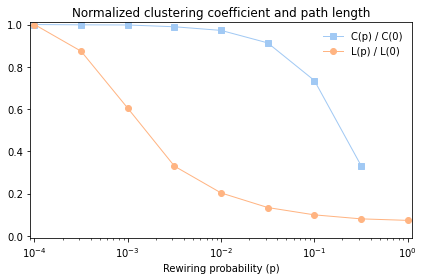

In [45]:
plt.plot(ps, C, 's-', linewidth=1, label='C(p) / C(0)')
plt.plot(ps, L, 'o-', linewidth=1, label='L(p) / L(0)')
decorate(xlabel='Rewiring probability (p)', xscale='log',
         title='Normalized clustering coefficient and path length',
         xlim=[0.00009, 1.1], ylim=[-0.01, 1.01])

savefig('figs/chap03-3')

## Breadth-first search

Now let's see how the shortest path algorithm works.  We'll start with BFS, which is the basis for Dijkstra's algorithm.

Here's our old friend, the ring lattice:

In [46]:
lattice = make_ring_lattice(10, 4)

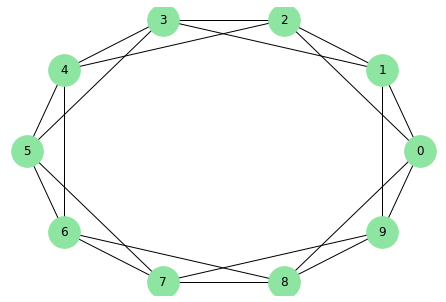

In [47]:
nx.draw_circular(lattice, 
                 node_color='C2', 
                 node_size=1000, 
                 with_labels=True)

And here's my implementation of BFS using a deque.

In [48]:
from collections import deque

def reachable_nodes_bfs(G, start):
    """Finds reachable nodes by BFS.
    
    G: graph
    start: node to start at
    
    returns: set of reachable nodes
    """
    seen = set()
    queue = deque([start])
    while queue:
        node = queue.popleft()
        if node not in seen:
            seen.add(node)
            queue.extend(G.neighbors(node))
    return seen

It works:

In [49]:
reachable_nodes_bfs(lattice, 0)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

Here's a version that's a little faster, but maybe less readable.

In [50]:
def reachable_nodes_bfs(G, start):
    """Finds reachable nodes by BFS.
    
    G: graph
    start: node to start at
    
    returns: set of reachable nodes
    """
    seen = set()
    queue = deque([start])
    while queue:
        node = queue.popleft()
        if node not in seen:
            seen.add(node)
            neighbors = set(G[node]) - seen
            queue.extend(neighbors)
    return seen

It works, too.

In [51]:
reachable_nodes_bfs(lattice, 0)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

## Dijkstra's algorithm

Now we're ready for Dijkstra's algorithm, at least for graphs where all the edges have the same weight/length.

In [52]:
def shortest_path_dijkstra(G, source):
    """Finds shortest paths from `source` to all other nodes.
    
    G: graph
    source: node to start at
    
    returns: make from node to path length
    """
    dist = {source: 0}
    queue = deque([source])
    while queue:
        node = queue.popleft()
        new_dist = dist[node] + 1

        neighbors = set(G[node]).difference(dist)
        for n in neighbors:
            dist[n] = new_dist
        
        queue.extend(neighbors)
    return dist

Again, we'll test it on a ring lattice.

In [53]:
lattice = make_ring_lattice(10, 4)

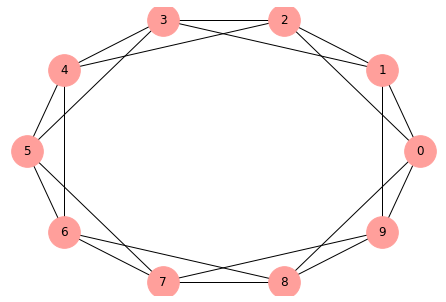

In [54]:
nx.draw_circular(lattice, 
                 node_color='C3', 
                 node_size=1000, 
                 with_labels=True)

Here's my implementation:

In [55]:
d1 = shortest_path_dijkstra(lattice, 0)
d1

{0: 0, 8: 1, 1: 1, 2: 1, 9: 1, 6: 2, 7: 2, 3: 2, 4: 2, 5: 3}

And here's the result from NetworkX:

In [56]:
d2 = nx.shortest_path_length(lattice, 0)
d2

{0: 0, 8: 1, 1: 1, 2: 1, 9: 1, 3: 2, 4: 2, 6: 2, 7: 2, 5: 3}

They are the same:

In [57]:
d1 == d2

True

**Exercise:** In a ring lattice with `n=1000` and `k=10`, which node is farthest from 0 and how far is it?  Use `shortest_path_dijkstra` to check your answer.

Note: the maximum distance between two nodes is the **diameter** of the graph.

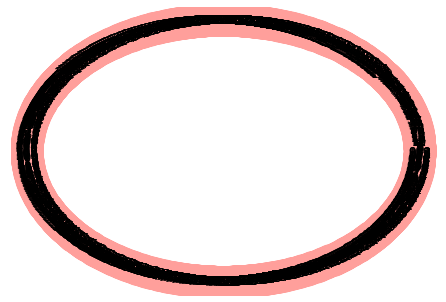

In [58]:
# Solution goes here
lattice = make_ring_lattice(1000, 10)
nx.draw_circular(lattice, 
                 node_color='C3', 
                 node_size=1000, 
                 with_labels=True)

In [59]:
# Solution goes here
# In a ring lattice, if the number of nodes is even, furthest node from  0 should be (number of nodes)/2, 
# the set of nodes with the longest shortest paths would be [(number of nodes)/2] + [(k/2)-1] 
# and [(number of nodes)/2] - [(k/2)-1].
# In the example above, it's 500 as the middle node in the set of nodes furthest from 0. The entire set
# would be from 500-4 to 500+4, which is 496-504 inclusive.

In [60]:
# Solution goes here
d3 = shortest_path_dijkstra(lattice, 0)
d3

{0: 0,
 1: 1,
 2: 1,
 3: 1,
 4: 1,
 5: 1,
 995: 1,
 996: 1,
 997: 1,
 998: 1,
 999: 1,
 6: 2,
 7: 2,
 8: 2,
 9: 2,
 10: 2,
 992: 2,
 993: 2,
 994: 2,
 990: 2,
 991: 2,
 11: 3,
 12: 3,
 13: 3,
 14: 3,
 15: 3,
 987: 3,
 988: 3,
 989: 3,
 985: 3,
 986: 3,
 16: 4,
 17: 4,
 18: 4,
 19: 4,
 20: 4,
 984: 4,
 982: 4,
 983: 4,
 980: 4,
 981: 4,
 21: 5,
 22: 5,
 23: 5,
 24: 5,
 25: 5,
 979: 5,
 977: 5,
 978: 5,
 976: 5,
 975: 5,
 26: 6,
 27: 6,
 28: 6,
 29: 6,
 30: 6,
 974: 6,
 972: 6,
 973: 6,
 971: 6,
 970: 6,
 31: 7,
 32: 7,
 33: 7,
 34: 7,
 35: 7,
 969: 7,
 968: 7,
 967: 7,
 966: 7,
 965: 7,
 36: 8,
 37: 8,
 38: 8,
 39: 8,
 40: 8,
 964: 8,
 963: 8,
 962: 8,
 961: 8,
 960: 8,
 41: 9,
 42: 9,
 43: 9,
 44: 9,
 45: 9,
 959: 9,
 958: 9,
 957: 9,
 956: 9,
 955: 9,
 46: 10,
 47: 10,
 48: 10,
 49: 10,
 50: 10,
 954: 10,
 953: 10,
 952: 10,
 951: 10,
 950: 10,
 51: 11,
 52: 11,
 53: 11,
 54: 11,
 55: 11,
 949: 11,
 948: 11,
 947: 11,
 946: 11,
 945: 11,
 56: 12,
 57: 12,
 58: 12,
 59: 12,
 60: 12,
 9

## Exercises

**Exercise:** In a ring lattice, every node has the same number of neighbors.  The number of neighbors is called the **degree** of the node, and a graph where all nodes have the same degree is called a **regular graph**.

All ring lattices are regular, but not all regular graphs are ring lattices.  In particular, if `k` is odd, we can't construct a ring lattice, but we might be able to construct a regular graph.

Write a function called `make_regular_graph` that takes `n` and `k` and returns a regular graph that contains `n` nodes, where every node has `k` neighbors.  If it's not possible to make a regular graph with the given values of `n` and `k`, the function should raise a `ValueError`.

In [61]:
# Here's `adjacent_edges` again for comparison:

def adjacent_edges(nodes, halfk):
    n = len(nodes)
    for i, u in enumerate(nodes):
        for j in range(i+1, i+halfk+1):
            v = nodes[j % n]
            yield u, v

In [62]:
# Solution goes here

import itertools, random, collections

def feasibility(n,k):
    if n>=(k+1) and n*k%2==0:
        return True
    else:
        return False

def make_regular_graph(n,k):
    
    # Check if graph is even feasible:
    if feasibility(n,k):
        pass
    else:
        return "ValueError"
    
    G = nx.Graph()
    G.add_nodes_from(range(n))

    stist = [list(range(0,k)) for i in range(n)]

    a = list(itertools.combinations(range(n),2))
    print(a)
    random.shuffle(a)

    stsum = 1
    while stsum != 0:
        
        proposal = a.pop()

        u = proposal[0]
        v = proposal[1]

        if stist[u] != False and stist[v] != False :
            G.add_edge(u, v)
            stist[u].pop()
            stist[v].pop()

            if len(stist[u]) == 0:
                stist[u] = False

            if len(stist[v]) == 0:
                stist[v] = False

        try:
            sum(stist)

        except TypeError:
            pass
        else:
            stsum = sum(stist)
    return G

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (5, 8), (5, 9), (6, 7), (6, 8), (6, 9), (7, 8), (7, 9), (8, 9)]


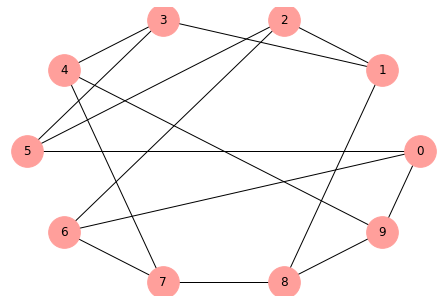

In [63]:
# Solution goes here
reg = make_regular_graph(10,3)
nx.draw_circular(reg, 
                 node_color='C3', 
                 node_size=1000, 
                 with_labels=True)

**Exercise:** My implementation of `reachable_nodes_bfs` is efficient in the sense that it is in $O(n + m)$, but it incurs a lot of overhead adding nodes to the queue and removing them.  NetworkX provides a simple, fast implementation of BFS, available from [the NetworkX repository on GitHub](https://github.com/networkx/networkx/blob/master/networkx/algorithms/components/connected.py).

Here is a version I modified to return a set of nodes:

In [64]:
def plain_bfs(G, start):
    """A fast BFS node generator"""
    seen = set()
    nextlevel = {start}
    while nextlevel:
        thislevel = nextlevel
        nextlevel = set()
        for v in thislevel:
            if v not in seen:
                seen.add(v)
                nextlevel.update(G[v])
    return seen

Compare this function to `reachable_nodes_bfs` and see which is faster.  Then see if you can modify this function to implement a faster version of `shortest_path_dijkstra`

In [65]:
# Solution goes here
%timeit len(reachable_nodes_bfs(reg, 0))
%timeit len(plain_bfs(reg, 0))

12.8 µs ± 425 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
11.3 µs ± 240 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [102]:
# Solution goes here
def plain_shortest_path_dijkstra(G, source, seen, dist, it):
    """
    Finds shortest paths from `source` 
    to all other nodes using DFS.
    
    G: graph
    source: node to start at
    
    returns: make from node to path length
    """

    if len(source) == 0:
        return dist

    for _ in range(len(source)):
        
        node = source.popleft()
        neighbors = G[node]
        seen.add(node)
        source.extend(set(neighbors))
        dist[node] = it

    source = deque(set(source).difference(seen))
    return plain_shortest_path_dijkstra(G, source, seen, dist, it+1)

def psp_dijkstra(G, source):
    d = plain_shortest_path_dijkstra(G, source=deque([source]), seen=set(), dist={}, it=0)
    return d

# Code below also works, but I wanted to implement this recursively as well.
#     dist = {source: 0}
#     length = 0
#     nextlevel = {source}
#     seen = set()
#     while nextlevel:
#         thislevel = nextlevel
#         nextlevel = set()

#         for v in thislevel:
#             neighbors = G[v]
#             seen.add(v)
#             nextlevel.update(set(neighbors)-seen)
#             print(length)
#             dist.update(dict(zip(neighbors, [length]*len(neighbors))))
            
#         length += 1
#     return dist      


In [103]:
# Solution goes here
lattice = make_ring_lattice(100, 16)

In [104]:
# Solution goes here
%timeit len(shortest_path_dijkstra(lattice, 0))
%timeit len(psp_dijkstra(lattice, 0))

153 µs ± 4.23 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
192 µs ± 11.2 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Turns out, the recursive Dijkstra algorithm takes longer, but it was still fun to write.

**Exercise:** The following implementation of a BFS contains two performance errors.  What are
they?  What is the actual order of growth for this algorithm?

In [105]:
def bfs(G, start):
    """Breadth-first search on a graph, starting at top_node."""
    visited = set()
    queue = [start]
    while len(queue):
        curr_node = queue.pop(0)    # Dequeue
        visited.add(curr_node)

        # Enqueue non-visited and non-enqueued children
        queue.extend(c for c in G[curr_node]
                     if c not in visited and c not in queue)
    return visited

In [106]:
# Solution goes here

# 1. the stack should be popped from the end, not the beginning
# 2. queue.extend should be used on the difference between the sets
#    created from G[curr_node], visited, and queue
# O(n^4) because while loop, popping queue from the beginning,
# the for-loop in queue.extend(), and checking whether each element
# is in the queue each run in O(n) time.

**Exercise:** In the book, I claimed that Dijkstra's algorithm does not work unless it uses BFS.  Write a version of `shortest_path_dijkstra` that uses DFS and test it on a few examples to see what goes wrong.

In [107]:
# Solution goes here
def DFS_shortest_path_dijkstra(G, source):
    """
    Finds shortest paths from `source` 
    to all other nodes using DFS.
    
    G: graph
    source: node to start at
    
    returns: make from node to path length
    """
    dist = {source: 0}
    queue = deque([source])
    while queue:
        
        # LIFO instead of FIFO
        node = queue.pop()
        new_dist = dist[node] + 1
        
        neighbors = set(G[node]).difference(dist)
        queue.extend(neighbors)
        
        for n in neighbors:
            dist[n] = new_dist
        
    return dist

In [108]:
lattice = make_ring_lattice(10,3)
d3 = DFS_shortest_path_dijkstra(lattice, 0)
d3

{0: 0, 1: 1, 9: 1, 8: 2, 7: 3, 6: 4, 5: 5, 4: 6, 3: 7, 2: 8}

There are a couple more questions:

**Exercise 3.5:** A natural question about the Watts and Strogatz paper is whether the small world phenomenon is specific to their generative model or whether other similar models yield the same qualitative result (high clustering and low path lengths).
- Instead of starting with a regular graph, start with another graph with high clustering. For example, you could put nodes at random locations in a 2-D space and connect each node to its nearest k neighbors. 
- Experiment with different kinds of rewiring. 

**Exercise 3.6:** Dijkstra's algorithm solves the \single source shortest path" problem, but to compute the characteristic path length of a graph, we actually want to solve the \all pairs shortest path" problem. Of course, one option is to run Dijkstra's algorithm n times, once for each starting node. And for some applications, that's probably good enough. But there are are more efficient alternatives. Find an algorithm for the all-pairs shortest path problem and implement it. See http://thinkcomplex.com/short. Compare the run time of your implementation with running Dijkstra's al-gorithm n times. Which algorithm is better in theory? Which is better in practice? Which one does NetworkX use?

I will get back to these later if I have time.